# Code for our processing of data that includes more features

#### Mount the google drive to read the files
- *(Data was stored and used from my google drive)*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
from bs4 import BeautifulSoup
import pickle
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
import pickle

with open ('/content/drive/My Drive/Colab Notebooks/hamfile', 'rb') as fp:
    ham_list = pickle.load(fp)
df_ham = pd.DataFrame(ham_list, columns=['type', 'header', 'body'])

In [0]:
with open ('/content/drive/My Drive/Colab Notebooks/2019spamfile', 'rb') as fp:
    spam_list = pickle.load(fp)
df_spam = pd.DataFrame(spam_list, columns=['type', 'header', 'body'])

Use below if creating the train set for the real-life scenario with the old emails. If not use above

In [0]:
with open ('/content/drive/My Drive/Colab Notebooks/oldspamfile', 'rb') as fp:
    spam_list = pickle.load(fp)
df_spam = pd.DataFrame(spam_list, columns=['type', 'header', 'body'])

In [0]:
# add these two dataframes together and shuffle them
df = df_ham.append(df_spam, ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
df.head()

,type,header,body
0,spam,Return-Path: <SRS0=EwcN5Z=VM=hasitems.com=sand...,"\n<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01..."
1,ham,Message-ID: <18531104.1075845109257.JavaMail.e...,\n\nSee attached letter\n\n
2,ham,Message-ID: <430403.1075852995713.JavaMail.eva...,\n\nWe were working on this deal for about 3 y...
3,ham,Message-ID: <14521305.1075856608466.JavaMail.e...,"\n\n \n\nVince,\n\nmore fuel for our discussio..."
4,spam,Return-Path: <SRS0=0K65w7=SS=exterten.top=nadi...,\n<!DOCTYPE html>\n<html>\n<head>\n=09<title><...


In [8]:
print(df.body[0])


<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">
<html>
  <head>
    <title></title>
  </head>
  <body>
    <table>
      <tr>
        <td colspan='2' align='center' valign='middle' class='preview-mid'>
          <br>
          <center>
            <a href="http://hsuFX639MW2Hqwh.hasitems.com/2088499c1cf61d450765b0903629b416_32c12c5d-010102080001/1/"><img src="http://jfs66PJ912TEqbs.hasitems.com/images//4b128133049378e3ada14074cef6e9ae" border="0" alt=""></a>
          </center>
          <div align="center">
            <font face="Verdana, Arial, Helvetica, sans-serif" size="1"><br>
          Get off the list? <a href="http://ocx0X08R98T4gjb.hasitems.com/2086a3674dd61d450765b090362ab416_32c12c5d-010102080001/1/"><font color="#666666"> Here</font></a>.<br>
           11041 Santa Monica Blvd. #301 Los Angeles, CA 90025
</font>
          </div>
        </td>
      </tr>
    </table>
  </body>
<p align="justify" style="color:#FFFFFF; width:371px; font-size:5.6px;">       

##### number of words

In [9]:
df = df[pd.notnull(df['type'])]
print(df['body'].apply(lambda x: len(x.split(' '))).sum())

27617517


### The split of the two classes

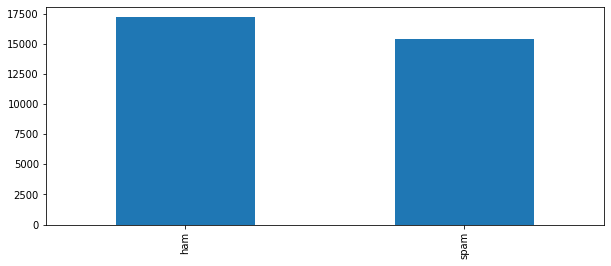

In [0]:
my_types = ['spam', 'ham']
plt.figure(figsize=(10,4))
df['type'].value_counts().plot(kind='bar');

In [0]:
df['type'].value_counts()

ham     17187
spam    15428
Name: type, dtype: int64

## Pre-processing

- HTML decoding
 - replace html link tags (`<a>`) with the word `link`, 
 - image tags (`<img>`) with the word `image`
 - image tags which have links hidden in them (eg: `<a href=’..’ <img .. ></a>`) as `image_with_link` 
- mobile numbers will be replaced by the word `tele_number`.
- Lemmatization
- removing stop words
- convert text to lower case
- remove punctuation and bad characters 

In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\n\r\t\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
TELE_RE = re.compile('(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})')
STOPWORDS = set(stopwords.words('english'))
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = TELE_RE.sub('tele_number', text) # replace TELE_RE symbols by tele number 
    
    # HTML decoding
    soup = BeautifulSoup(text, "html.parser")
    for a in soup("a"):
      if a("img"):
        a.replace_with("image_with_link ") # clickable images
        continue
      a.replace_with("link ") # links
    for img in soup("img"):
      img.replace_with("image ") #images
    text = soup.get_text()
    
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    # Lemmatization
    word_list = nltk.word_tokenize(text) # Tokenize: Split the sentence into words
    lemmatizer = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list]) # Lemmatize list of words and join
    text = lemmatized_output

    return text
    
df['body'] = df['body'].apply(clean_text)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,type,header,body
0,spam,Return-Path: <SRS0=EwcN5Z=VM=hasitems.com=sand...,title head image_with_link
1,ham,Message-ID: <18531104.1075845109257.JavaMail.e...,see attached letter
2,ham,Message-ID: <430403.1075852995713.JavaMail.eva...,working deal 3 year original message milnthorp...
3,ham,Message-ID: <14521305.1075856608466.JavaMail.e...,vince fuel discussion john sheriff today mike ...
4,spam,Return-Path: <SRS0=0K65w7=SS=exterten.top=nadi...,09 title head image_with_link


In [12]:
print(df.body[10])

anita problem vince anita dupont enron 08 18 2000 1027 shirley crenshaw hou ect ect cc vince j kaminski hou ect ect subject white wall board shirely amitava want one wall size white marker board office go ordering one anita


#### Save in drive for later use

In [0]:
df.to_pickle('/content/drive/My Drive/Colab Notebooks/ham_2019spam_cleaned_df_v2') 

# use below if using this to obtain data of old emails for the real-life scenario
# df.to_pickle('/content/drive/My Drive/Colab Notebooks/ham_old_spam_cleaned_df_v2') 